# Route Generator

## Inputs
- File containing the road network
- File containing the link parameters such as travel time, waiting time, toll fare.
- File containing the position, destination for each agent
- File containing the agent parameters

## Outputs
- File containing plans for all agents with scores

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import random
import os
import xml.etree.ElementTree as et
import csv 

%matplotlib inline

### Helper Functions

In [2]:
def drawNetwork(G, show_edge_information=True):
    '''
    Helper function to plot the network for visualization
    
    Return values:
        G - road network as a networkx graph
    '''
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(12, 12))    
    nx.draw(G,pos,labels={node:node for node in G.nodes()},node_color='g')
    if show_edge_information:
        edge_labels = {
            (a,b):
            "%.2f" % round(nx.get_edge_attributes(G,'p_1')[(a,b) if a<b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_2')[(a,b) if a<b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_3')[(a,b) if a<b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_4')[(a,b) if a<b else (b,a)],2) + '\n' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_1')[(a,b) if a>b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_2')[(a,b) if a>b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_3')[(a,b) if a>b else (b,a)],2) + ', ' +
            "%.2f" % round(nx.get_edge_attributes(G,'p_4')[(a,b) if a>b else (b,a)],2)
            for a,b in G.edges()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='r')
    plt.axis('off')
    plt.show()

### Parameters

In [3]:
n_params = 4 # No. of link parameters
n_plans = 4 # No. of plans per agent
interval = 5*60 # Number of seconds each iteration
max_time_per_plan = 10*60 # Number of seconds to generate plans for


nodes_file = '../config/SUMO/testNewGrid.nod.xml'
edges_file = '../config/SUMO/testNewGrid.edg.xml'
prefs_file = '../config/Agents/preferences.csv'
trips_file = '../config/Agents/trips.csv'
dataset_path = '../output/dataset/'


current_time = 0*60

### Core Functionality

In [4]:
def getNetworkFromFile(path):
    '''
    Creates a network using the networkx library using the file containing the road network
    
    Parameters:
        path    - path to input file containing road network
    
    Return values:
        G       - graph of networkx which contains the road network 
        n_nodes - number of nodes read
    '''
   
    root = et.parse(path).getroot()
    
    G = nx.DiGraph()
    
    for child in root:
        G.add_node(child.attrib['id'],
                   pos=(int(child.attrib['x']),int(child.attrib['y'])))
    
    n_nodes = len(root.getchildren())
    
    return G,n_nodes

In [5]:
def getNetworkWithLinkParameters(G, path):
    '''
    Adds the link parameters (waiting time, travel time, etc to the road network)
    
    Parameters:
        G       - input road network as a networkx graph
        path    - path to input file containing network parameters
        
    Return values:
        G       - road network with parameters added
        n_links - number of links read
    '''
    
    n_links = 0
    root = et.parse(path).getroot()
    for child in root:
        G.add_edge(child.attrib['from'], child.attrib['to'],
                   link_id = child.attrib['id'],
                   easy_link_id = n_links,
                   p_1=np.random.normal(1,0.2),
                   p_2=np.random.normal(1,0.2),
                   p_3=np.random.normal(1,0.2),
                   p_4=np.random.normal(1,0.2))
        n_links = n_links + 1
    
    return G, n_links

In [6]:
def getAgentPreferencesFromFile(path):
    '''
    Read preferences of all agents from file
    
    Parameters:
        path        - path to input file containing preferences
        
    Return values:
        agent_prefs - dict containing preferences for each agents
        n_prefs     - no of preferences read
    '''
    
    with open(path, mode='r') as infile:
        reader = csv.reader(infile)
        num_vals = len(next(reader)) - 1 
        agent_prefs = {rows[0]:{'w_'+str(i+1):float(rows[i+1]) for i in range(num_vals)} for rows in reader}
    
    n_prefs = len(agent_prefs)
    
    return agent_prefs, n_prefs    

In [7]:
def getTripsFromFile(path):
    '''
    Read trips of all agents from file
    
    Parameters:
        path          - path to input file containing all trips
        
    Return values:
        agent_trips   - list containing trips for each agent
        n_trips       - number of trips read
    '''
    
    with open(path, mode='r') as infile:
        reader = csv.reader(infile)
        num_vals = len(next(reader)) - 1 
        agent_trips = {rows[0]:{'start':int(rows[1]),'dest':int(rows[2]),'time':int(rows[3])} for rows in reader}
    
    n_trips = len(agent_trips)
    
    return agent_trips, n_trips

In [8]:
def getCompletedTripsFromFile(path):
    '''
    Inputs file which has list of agents which completed
    their trips upto the previous iteration
    
    Parameters:
        path            - path to file containing said list
        
    Return values:
        completed_trips - list read from file
    '''
    
    completed_trips = []
    return completed_trips

In [9]:
def getPlansForTrips(G, agent_trips, agent_prefs, n_links):
    '''
    Inputs trips and generates plans
    
    Parameters:
        G           - road network as a networkx graph
        agent_trips - list containing trips for all agents 
        agent_prefs - dict containing agent preferences
        n_links     - number of links in the road network 
        
    Return values:
        plans       - dict containing plans for each agent
    '''
    
    # Plan structure is shown below
    # plans = {'agent_1':{'plan_1':[0,0,1,0,1,0,0],
    #                     'plan_2':[0,1,0,0,0,1,0],
    #                     'plan_3':[0,0,1,0,0,0,1],
    #                     'plan_4':[1,0,0,0,1,0,0],
    #                     'cost_1':1.34,
    #                     'cost_2':1.07,
    #                     'cost_3':1.71,
    #                     'cost_4':1.92},
    #          'agent_2':{'plan_1':[0,0,1,0,1,0,0],
    #                     'plan_2':[0,1,0,0,0,1,0],
    #                     'plan_3':[0,0,1,0,0,0,1],
    #                     'plan_4':[1,0,0,0,1,0,0],
    #                     'score_1':1.34,
    #                     'score_2':1.07,
    #                     'score_3':1.71,
    #                     'score_4':1.92},
    #          ... }
    
    global n_params
    
    plans = {}
    
    plan = [0] * n_links # plan = [0 0 0 0 ... 0] 
    
    ids = nx.get_edge_attributes(G,'easy_link_id')
    
    params = {}
    for i in range(n_params):
        params['p_'+str(i+1)] = nx.get_edge_attributes(G,'p_'+str(i+1))
        
    for agent_id, agent_trip in agent_trips.items():
        
        plans[agent_id] = {}
        
        # getting preferences for current agent
        this_prefs = agent_prefs[agent_id]
        
        for i in range(n_params):    
            
            # creating a copy of template
            this_plan = list(plan)
            
            this_score = 0
            this_time = 0
            
            # getting route based on minimizing parameter p_i
            route = nx.dijkstra_path(G, 
                                     'n%d'%agent_trip['start'], 
                                     'n%d'%agent_trip['dest'],
                                     'p_'+str(i+1))
            
            for j in range(len(route)-1):
                # setting my_plan[link_id] = 1 if link used
                this_link = (route[j],route[j+1])
                
                # The time for the plan so far is checked and the edge is set to 1 
                # only if it is being used in the next max_time_per_plan time units
                # However, the score is calculated for the whole plan because it is
                # possible that a plan is saving me cost now but it later has a toll
                # which I don't want to pay
                if this_time < max_time_per_plan:
                    this_plan[ids[this_link]] = 1
                    # adding time
                    this_time += params['p_1'][this_link]*60

                # adding link costs weighted with preferences to score
                for k in range(n_params):
                    this_score += params['p_'+str(k+1)][this_link] * this_prefs['w_'+str(k+1)]
            
            plans[agent_id]['plan_'+str(i+1)] = this_plan
            plans[agent_id]['score_'+str(i+1)] = this_score
            plans[agent_id]['time_'+str(i+1)] = this_time
    
    return plans

In [10]:
def writePlansToFiles(dataset_path,plans):
    '''
    Writes agent plans to file
    
    Parameters:
        dataset_path - path to write the plans
        plans        - agent plans
    
    Return values:
        None
    '''
    global n_plans
    
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    for agent in plans:
        filename = agent + '.plans'
        with open(os.path.join(dataset_path, filename), 'w') as f:
            for i in range(1,n_plans+1):
                cost_str = str(plans[agent]['score_'+str(i)])
                plan_str = ','.join(map(str, plans[agent]['plan_'+str(i)]))
                f.write(cost_str+":"+plan_str+"\n")

### Main Script

In [11]:
G, n_nodes = getNetworkFromFile(nodes_file)
print('Generating road network with', n_nodes, 'nodes')

Generating road network with 100 nodes


In [12]:
G, n_links = getNetworkWithLinkParameters(G,edges_file)
print('Added', n_links, 'links to the network')

Added 360 links to the network


In [13]:
agent_prefs, n_prefs = getAgentPreferencesFromFile(prefs_file)
print(n_prefs,'preferences read from file')

100 preferences read from file


In [14]:
agent_trips, n_trips = getTripsFromFile(trips_file)
print(n_trips,'trips read from file')

100 trips read from file


In [15]:
# TODO
completed_trips_prev = getCompletedTripsFromFile('/path/to/foo')
print('%d agents had completed their trips before this iteration!'%len(completed_trips_prev))

0 agents had completed their trips before this iteration!


In [16]:
agent_plans = getPlansForTrips(G, agent_trips, agent_prefs, n_links)
print("Plans generated!")

Plans generated!


In [17]:
writePlansToFiles(dataset_path,agent_plans)
print("Wrote generated plans to: " + dataset_path)

Wrote generated plans to: ../dataset/


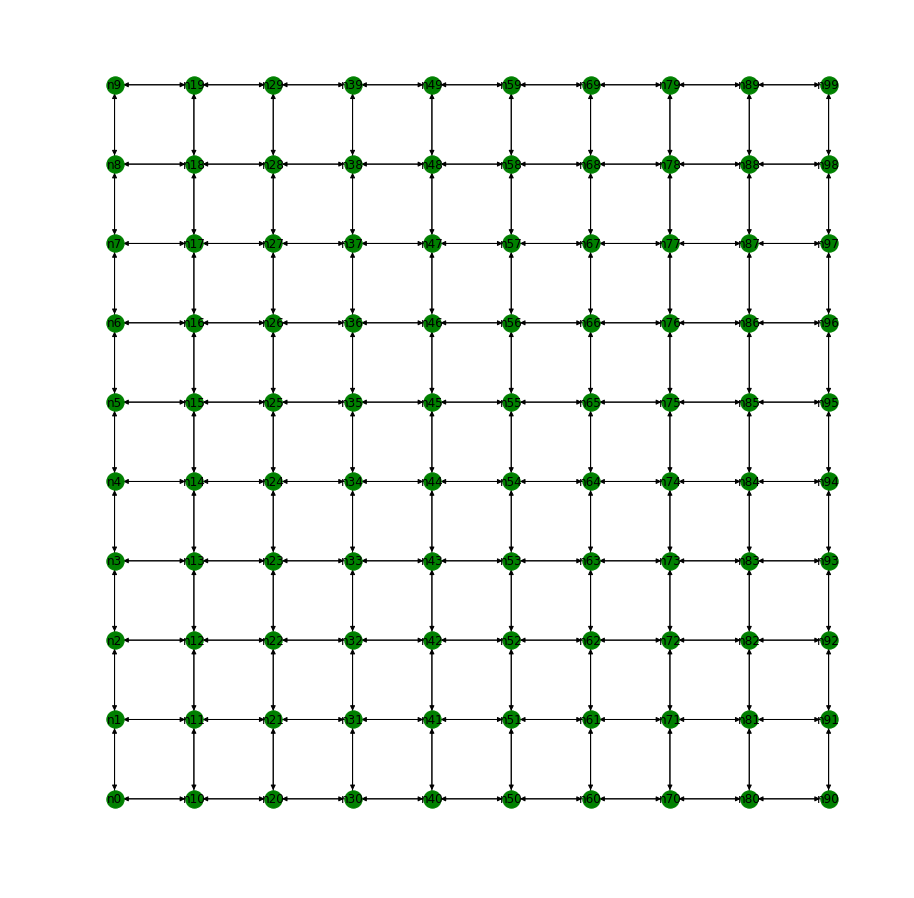

In [18]:
drawNetwork(G, show_edge_information=False)

## TODO:
- Read the current position of agents and plan routes accordingly